##**Mount google drive to access data**
(in this case it's in a specific folder in My Drive)

In [1]:
from google.colab import drive
drive.mount('/content/drive')
rec_dir = '/content/drive/My Drive/StarTrekDemo/resources'
data_dir = '/content/drive/My Drive/StarTrekDemo/data'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


##**Read in reformatted Star Trek script json files from two differnent series**
 - The Original Series (TOS)
 - The Next Generation (TNG)
 
*(subset of dataset @ https://www.kaggle.com/gjbroughton/start-trek-scripts)*

In [2]:
import os
import json

original = json.load(open(os.path.join(data_dir,'original_reformatted.json'),'r'))
next_gen = json.load(open(os.path.join(data_dir,'next_generation_reformatted.json'),'r'))

print("{} Original Star Trek episodes".format(len(original)))
print("{} Next Generation episodes".format(len(next_gen)))

80 Original Star Trek episodes
176 Next Generation episodes


##**Slightly unbalanced classes, but not horrible**

And the format?

*(post some preprocessing and unmungingk...now we've got single episodes mapped to a single text object)*

**Original Star Trek: Episode 44 "The Trouble with Tribbles"**

In [3]:
print('{}....\n\n{}....\n\n{}....'.format(original['episode 44'][0:150],original['episode 44'][856:965],original['episode 44'][-198:]))

captain kirk
captain it is not necessary to remind you of the importance to the federation of shermans planet the key to our winning of this planet is....

a mere two men for a project of this importance starfleet command
kirk this station is swarming with klingons....

seem to be all over the ship
but they do give us something mister spock they give us love well cyrano jones says a tribble is the only love that money can buy
yes captain
aye aye
aye
aye aye captain....


##**More preprocessing and feature extraction**
...so offline I already ran parallel word segmentation to fix some munged Next Generation scripts and compiled a list of names identified using spaCy NER

Now: 

-  tokenizing (although that's essentially done with the word segmentation)
-  lemmatization (some standardization so that 'walking' and 'walked' are the same feature)
-  exclude punctuation, numbers, certain parts of speech, and itty bitty tokens, 
because in this case I don't expect a ton of important features to come from abbreviations, acronyms, etc

*(this will take a couple minutes and could be improved but I kinda like the visibility of the loops here)*

In [4]:
import spacy
import re
eng_mod = spacy.load("en_core_web_sm")
x1 = []
y = []

print ('loading features from script instances')
for label, dataset in ({0:original,1:next_gen}).items():
    print ('processing class: {}'.format(label))
    for episode, script in dataset.items():
      doc = eng_mod(script.replace('\n',' '))       
      all_tokens = [t.lemma_ for t in doc if not t.is_stop\
                    and t.pos_ not in ['AUX','PART','PUNCT','NUM'] and not \
                    re.search('[\d]',t.lower_) and len(t.lower_) > 2]
      
      x1.append(all_tokens)
      y.append(label)
print ('feauture dictionaries loaded')
print ('{} total instances'.format(len(x1)))


loading features from script instances
processing class: 0
processing class: 1
feauture dictionaries loaded
256 total instances


##What do the instances look like now?
let's split up train test sets

*note that the '44th' (really 45th) instance of the **training** set, is not 'episode 44'; The Trouble with Tribbles*

for one, the index in the list of instances is not the same as the string key in the original dictionary...two, we've split up those instances into two different sets

In [5]:
from random import sample
from sklearn.model_selection import train_test_split

X1_train, X1_test, y_train, y_test = train_test_split(x1, y, test_size=0.3, random_state=5)

print (X1_train[44])


['governor', 'delaplane', 'pacifica', 'inform', 'cancel', 'schedule', 'stop', 'true', 'explain', 'captain', 'return', 'earth', 'yes', 'delighted', 'elaborate', 'trouble', 'greet', 'reception', 'area', 'minute', 'meet', 'commander', 'rem', 'mick', 'let', 'andoni', 'ante', 'wait', 'riker', 'tell', 'bring', 'yes', 'course', 'captain', 'enterprise', 'important', 'horatio', 'gentleman', 'awful', 'tragedy', 'terrible', 'loss', 'life', 'enjoy', 'picardi', 'believe', 'find', 'excellent', 'aperitif', 'know', 'conspiracy', 'captain', 'charming', 'thing', 'machination', 'real', 'know', 'suspect', 'real', 'wonderful', 'bantering', 'captain', 'give', 'appetite', 'sit', 'captain', 'wait', 'ahead', 'start', 'captain', 'stand', 'ceremony', 'eat', 'picard', 'raise', 'hand', 'want', 'second', 'mean', 'doctor', 'think', 'dark', 'intention', 'dramatic', 'way', 'think', 'say', 'brother', 'picard', 'riker', 'control', 'enterprise', 'mean', 'control', 'enterprise', 'emergency', 'communiqu', 'discuss', 'fello

##classify and predict using the counts of words/tokens and Naive Bayes 
 - the Multinomial part just means that we're taking into account how many times the features occur in each instance, and not simply whether or not they are present

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import make_pipeline

# a couple helper functions to feed the vectorizer 
# preprocessed text instead of just raw text
def dummy(doc):
    return doc

def get_vectorizer(n=None):
  return CountVectorizer(
    tokenizer=dummy,
    preprocessor=dummy,
    max_features=n
)  

# create pipeline and train model
cv1 = get_vectorizer()
model1 = make_pipeline(cv1, MultinomialNB())
model1.fit(X1_train, y_train)

# predict test instances
labels1 = model1.predict(X1_test)
print ('overall accuracy: {}'.format(model1.score(X1_test, y_test)))

# take a look at the results in a confusion matrix
def make_conf_matrix(y_test, y_pred):  
  mat = confusion_matrix(y_test, y_pred)
  sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
              xticklabels=['original','next generation'], 
              yticklabels=['original','next generation'])
  plt.xlabel('true label')
  plt.ylabel('predicted label');
  
make_conf_matrix(y_test, labels1)

overall accuracy: 1.0


##**Well that worked pretty well...maybe a little too well...**
### ...smells like...**information leak**



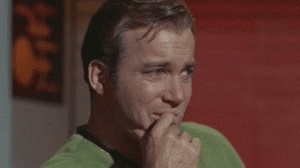

In [7]:
from IPython.display import Image
Image(filename=os.path.join(rec_dir,"kirk_pensive.gif.png"))

*(that was fun for me...I'm a big fan of gifs and I didn't realize you can imbed them in colab)*

## Maybe we should have started with a little data more exploration...

Let's throw together some vocab counts based on class labels so we have something to work with

In [0]:
def get_vocab_counts(dataset, labels, target):
  script_len = []
  vocab = []
  for i in range(len(dataset)):
    if labels[i] == target:
      script_len.append(len(dataset[i]))
      vocab.extend([token for token in dataset[i]])
  
  return vocab, script_len

vocab0, doc_len0 = get_vocab_counts(X1_train, y_train, 0)
vocab1, doc_len1 = get_vocab_counts(X1_train, y_train, 1)


## What if the overall length of the dialogues have very different distributions?

In [9]:
import numpy as np

def plot_data(d1, d2):
   fig, ax = plt.subplots()
   ax.hist(d1, 10,  None, ec='blue', fc='none', lw=1.5, histtype='step', label='original')
   ax.hist(d2, 10, None, ec='green', fc='none', lw=1.5, histtype='step', label='next gen')
   ax.legend(loc='upper left')
   plt.axvline(np.mean(d1), color='blue', linestyle='dashed', linewidth=1)
   plt.axvline(np.mean(d2), color='green', linestyle='dashed', linewidth=1)
   plt.show()

print ('Script Length Distribution')
plot_data(doc_len0, doc_len1)

Script Length Distribution


**doesn't really seem like they're all that different overall**

**What kinds of words tend to show up?**

*honestly, I think in terms of actual analytics, word clouds are a little silly, but they're still a great visualization and I had fun messing around with custom colors and image masking*

In [10]:
import numpy as np
from random import choice
from PIL import Image as img
from wordcloud import WordCloud
from random import choice


def generate_cloud(vocab):
  logo = np.array(img.open(os.path.join(rec_dir, 
                            "starfleet_logo_wt_background2.png")))
  # kinda hacky way to make the png into a legit mask 
  # by making "sorta whites" into "really white"
  logo[logo > 100] = 255
  
  def st_color_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    star_trek_colors = [(165,151,47), (148,54,62), (65,149,167), (211,211,211)]
    pick = choice(star_trek_colors)
    return "rgb({}, {}, {})".format(pick[0],pick[1],pick[2],0)
  
  
  # Read the whole text.
  text = ' '.join(vocab)

  wc = WordCloud(background_color="black", max_words=50, mask=logo,
                 contour_width=10, contour_color='grey', margin=2,min_font_size=6,
                 prefer_horizontal=0.8, relative_scaling = .6, scale = 6)

  # generate word cloud
  wc.generate(text)
  plt.figure(figsize=(10,10))
  plt.imshow(wc.recolor(color_func=st_color_func))#, interpolation='bilinear')
  # Hide grid lines and axes
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  plt.show()



generate_cloud(vocab0)
generate_cloud(vocab1)

##**Spock? Jim?**##

...and what's "**datum**"?

remember this line:
all_tokens = 

[t.lemma_ for t in doc if not t.is_stop...

*...doh...not a huge deal, but in an attempt to standardize by using lemmas, I managed to change a feature into something I didn't even recognize.*

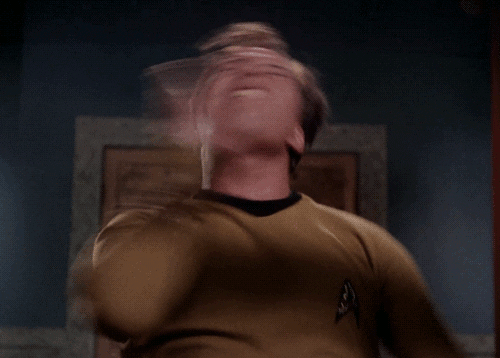

In [11]:
Image(filename=os.path.join(rec_dir,"kirk_slap.gif.png"))

##So if we were really trying to see if the vocabulary, predominant themes, etc were noticibly different...including names in our feature set is probably not what we want to do##

Let's take a look at how predictive the model thinks they are...

In [12]:
# get coefficients from model
def show_most_informative_features(vectorizer, clf, n=20):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names), reverse=True)
    for (coef_1, fn_1) in coefs_with_fns[:n]:
        print ("\t%.4f\t%-15s" % (coef_1, fn_1))

    
show_most_informative_features(cv1, model1[-1], 30)

	-4.3602	captain        
	-4.3944	sir            
	-4.6344	know           
	-5.0095	think          
	-5.0520	yes            
	-5.0547	datum          
	-5.0753	like           
	-5.1266	go             
	-5.1288	commander      
	-5.1518	ship           
	-5.1907	want           
	-5.2216	come           
	-5.2386	time           
	-5.2795	mister         
	-5.2838	right          
	-5.4104	doctor         
	-5.5082	find           
	-5.5104	way            
	-5.5576	good           
	-5.5781	tell           
	-5.5827	enterprise     
	-5.5966	need           
	-5.6569	let            
	-5.6910	look           
	-5.7131	get            
	-5.7276	try            
	-5.7824	worf           
	-5.7923	picard         
	-5.8227	ill            
	-5.8285	life           


## Let's make a new feature set without all the potential cheats and limit the vocab a bit more

In [17]:
# read in speakers from the original script and spaCy identified person entities
characters = set(json.load(open(os.path.join(data_dir, 'characters.json'),'r')))
#note...I included what I deemed to be a bunch of stop words in here as well.
ner_peeps = set(json.load(open(os.path.join(data_dir, 'spacy_ner_peeps.json'),'r')))
name_set = characters.union(ner_peeps)
print("{} Total characters with speaking lines in scripts".format(len(characters)))
print("{} Total person entities(+)".format(len(ner_peeps)))
print('{} Distinct new "stop words" \n'.format(len(name_set)))


# make new instances without the features of character names  
def strip_names(orig_dataset):
  new_dataset = []
  for episode in orig_dataset:
    new_dataset.append([word for word in episode if word not in name_set]) 
  return new_dataset

# reproduce instances and metadata
X2_train = strip_names(X1_train)
X2_test = strip_names(X1_test)

limit_vocab0, limit_doc_len0 = get_vocab_counts(X2_train, y_train, 0)
limit_vocab1, limit_doc_len1 = get_vocab_counts(X2_train, y_train, 1)

total_vocab = vocab0 + vocab1
limit_total_vocab = limit_vocab0 + limit_vocab1

print ('total training vocab: {}'.format(len(total_vocab)))
print ('limited training vocab: {}'.format(len(limit_total_vocab)))

print (X1_train[44])
print (X2_train[44])



1199 Total characters with speaking lines in scripts
2515 Total person entities(+)
2954 Distinct new "stop words" 

total training vocab: 320557
limited training vocab: 218928
['governor', 'delaplane', 'pacifica', 'inform', 'cancel', 'schedule', 'stop', 'true', 'explain', 'captain', 'return', 'earth', 'yes', 'delighted', 'elaborate', 'trouble', 'greet', 'reception', 'area', 'minute', 'meet', 'commander', 'rem', 'mick', 'let', 'andoni', 'ante', 'wait', 'riker', 'tell', 'bring', 'yes', 'course', 'captain', 'enterprise', 'important', 'horatio', 'gentleman', 'awful', 'tragedy', 'terrible', 'loss', 'life', 'enjoy', 'picardi', 'believe', 'find', 'excellent', 'aperitif', 'know', 'conspiracy', 'captain', 'charming', 'thing', 'machination', 'real', 'know', 'suspect', 'real', 'wonderful', 'bantering', 'captain', 'give', 'appetite', 'sit', 'captain', 'wait', 'ahead', 'start', 'captain', 'stand', 'ceremony', 'eat', 'picard', 'raise', 'hand', 'want', 'second', 'mean', 'doctor', 'think', 'dark', 'in

## Train a second model and check performance and top features

overall accuracy: 0.987012987012987


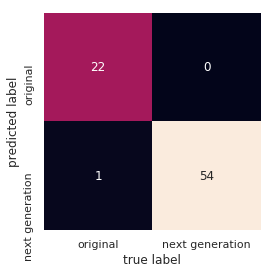

In [14]:
cv2 = get_vectorizer(10000)
model2 = make_pipeline(cv2, MultinomialNB())
model2.fit(X2_train, y_train)
labels2 = model2.predict(X2_test)
print ('overall accuracy: {}'.format(model2.score(X2_test, y_test)))

make_conf_matrix(y_test, labels2)
#show_most_informative_features(cv2, model2[-1], 25)

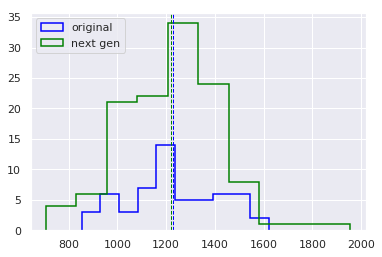

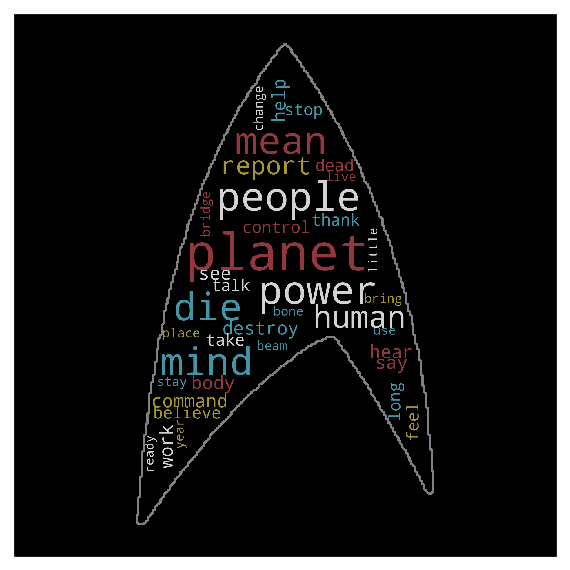

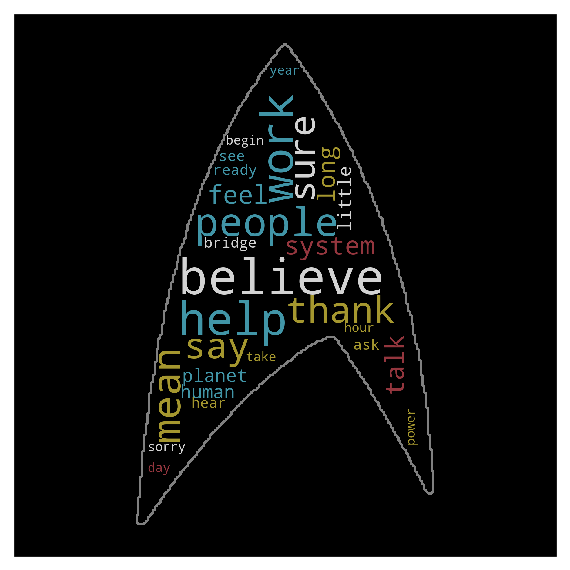

In [15]:
plot_data(limit_doc_len0, limit_doc_len1)

generate_cloud(limit_vocab0)
generate_cloud(limit_vocab1)

##This looks a lot more like we're capturing actual linguistic differences##

seems to be some notible differences here...

- Star Trek OG - destroy, power, die, planet
- Star Trek TNG - help, work, thank, system

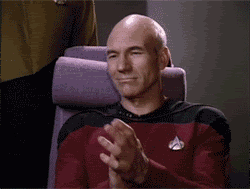

In [18]:
Image(filename=os.path.join(rec_dir,"picard_slow_clap.gif.png"))

## Some conditional probabilities of individual features

In [0]:
 
def conditionals(vocab0, vocab1, token, classes):
  # token probability given entire vocabulary
  try:
    p_of_token = (vocab0.count(token) + vocab1.count(token)) / (len(vocab0) + len(vocab1))
  
    # prior class probabilities
    p_of_0 = y_train.count(0)/len(y_train)
    p_of_1 = 1 - p_of_0

    # probability of token contitional on class
    p_of_token_given_0 = vocab0.count(token)/len(vocab0)
    p_of_token_given_1 = vocab1.count(token)/len(vocab1)

    p_of_0_given_target = p_of_token_given_0 * p_of_0  / p_of_token
    p_of_1_given_target = p_of_token_given_1 * p_of_1  / p_of_token
    print ('probability of original series versus next generation given \
            {} : {:.2f} - {:.2f} '.format(token, p_of_0_given_target, p_of_1_given_target))
   
  except:
    print ("{} not in vocab".format(token))
        

## Let's explore some differences in vocabulary

In [20]:
conditionals(limit_vocab0, limit_vocab1, 'tea', y_train)
conditionals(limit_vocab0, limit_vocab1, 'grain', y_train)
print ()
conditionals(limit_vocab0, limit_vocab1, 'gender', y_train)
conditionals(limit_vocab0, limit_vocab1, 'race', y_train)
print ()
conditionals(limit_vocab0, limit_vocab1, 'learn', y_train)
conditionals(limit_vocab0, limit_vocab1, 'adapt', y_train)
conditionals(limit_vocab0, limit_vocab1, 'overpower', y_train)
print ()
conditionals(limit_vocab0, limit_vocab1, 'war', y_train)
conditionals(limit_vocab0, limit_vocab1, 'die', y_train)
conditionals(limit_vocab0, limit_vocab1, 'battle', y_train)
conditionals(limit_vocab0, limit_vocab1, 'fight', y_train)
print ()
conditionals(limit_vocab0, limit_vocab1, 'family', y_train)
conditionals(limit_vocab0, limit_vocab1, 'maam', y_train)
conditionals(limit_vocab0, limit_vocab1, 'wife', y_train)
conditionals(limit_vocab0, limit_vocab1, 'son', y_train)
conditionals(limit_vocab0, limit_vocab1, 'mother', y_train)
print()
conditionals(limit_vocab0, limit_vocab1, 'sense', y_train)
conditionals(limit_vocab0, limit_vocab1, 'care', y_train)
conditionals(limit_vocab0, limit_vocab1, 'bold', y_train)
conditionals(limit_vocab0, limit_vocab1, 'illogical', y_train)


probability of original series versus next generation given            tea : 0.00 - 1.00 
probability of original series versus next generation given            grain : 1.00 - 0.00 

probability of original series versus next generation given            gender : 0.06 - 0.94 
probability of original series versus next generation given            race : 0.50 - 0.50 

probability of original series versus next generation given            learn : 0.29 - 0.71 
probability of original series versus next generation given            adapt : 0.44 - 0.56 
probability of original series versus next generation given            overpower : 0.60 - 0.40 

probability of original series versus next generation given            war : 0.35 - 0.65 
probability of original series versus next generation given            die : 0.47 - 0.53 
probability of original series versus next generation given            battle : 0.20 - 0.80 
probability of original series versus next generation given            fight :

## What about other types of information leak?
I would expect there to be substantial, clearly recognizable differences between a show in the 60-70's and a show in the 90's, especially sci-fi, which tends to be a vehicle for social commentary and critique.

But honestly, anything over 97% tends to make me raise an eyebrow and question...how might I be cheating the real problem?

- **data wrangling errors?**
  
    always a possibility really...but we were fairly careful about only using the training set
- **temporality?**
  
    the shows are **aired** as a sequential series - but if we are not necessarily trying to predict future episodes then maybe that's not so important. Even so, can we assume that later episodes carry over information from earlier ones? Or might we be suspect that * 

  
  

I'll say this - if I were going to put this into production, there would be a lot more investigation. but for now I'm short on time..so here's a little more food for thought and we'll leave it at that...while the overall lengths of the scripts is very similar, that doesn't mean they have similar lengths of vocabularies. Maybe Star Trek OG has long scripts, but they spend the marjority of the time just saying "aye...aye...aye sir". Implementing a binary version of bayes (just taking into acount whether or not a token appears instead of how many times) definitely changes the results.



overall accuracy: 0.922077922077922


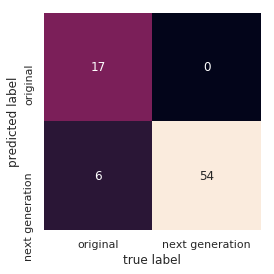

In [0]:
cv3 = get_vectorizer(10000)

model3 = make_pipeline(cv3, BernoulliNB())
model3.fit(X2_train, y_train)
labels3 = model3.predict(X2_test)
print ('overall accuracy: {}'.format(model3.score(X2_test, y_test)))

make_conf_matrix(y_test, labels3)


## Overall takehome
just a couple little changes make some pretty substantial differences...for example,
go back to that last BernoulliNB example and limit the features by a factor of ten

cv3 = get_vectorizer(1000)

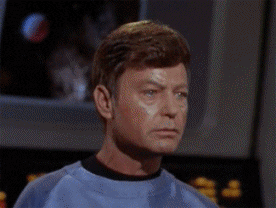

In [21]:

Image(filename=os.path.join(rec_dir,"agreed.gif.png"))

## What about other NLP tasks? ##
Honestly I think modeling individuals' speech and generating character specific sentences based on an input topic would be way more fun/interesting ...although potentially less generalizable

**"the topic is...cat memes...what would Data say?"**

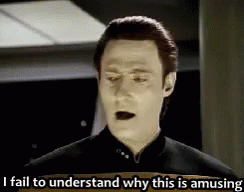

In [22]:
Image(filename=os.path.join(rec_dir,"data.gif.png"))